In [ ]:
import pandas as pd
import numpy as np

dados = pd.read_excel("https://github.com/alura-cursos/covid-19-clinical/blob/main/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx?raw=true")
dados.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,0.318681,0.898990,NaN,NaN,NaN,NaN,-0.275362,0.736842,NaN,NaN,NaN,NaN,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,-1.0,-0.871658,-0.871658,-0.871658,-0.871658,-1.0,-0.863874,-0.863874,-0.863874,-0.863874,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.414634,-0.414634,-0.414634,-0.414634,-1.0,-0.979069,-0.979069,...,-0.996762,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,0.033779,0.665932,-0.283951,-0.376923,-0.188679,-0.379310,0.035714,0.631579,-0.340206,-0.4875,-0.572650,-0.857143,0.098901,0.797980,-0.076923,0.286486,0.298507,0.272727,0.362319,0.947368,-0.33913,0.325153,0.114504,0.176471,-0.238095,-0.818182,-0.389967,0.407558,

In [ ]:
def preenche_tabela(dados):
    features_continuas_colunas = dados.iloc[:, 13:-2].columns
    features_continuas = dados.groupby("PATIENT_VISIT_IDENTIFIER", as_index=False)[features_continuas_colunas].fillna(method='bfill').fillna(method='ffill')
    features_categoricas = dados.iloc[:, :13]
    saida = dados.iloc[:, -2:]
    dados_finais = pd.concat([features_categoricas, features_continuas, saida], ignore_index=True,axis=1)
    dados_finais.columns = dados.columns
    return dados_finais

In [ ]:
dados_limpos = preenche_tabela(dados)
a_remover = dados_limpos.query("WINDOW=='0-2' and ICU==1")['PATIENT_VISIT_IDENTIFIER'].values
dados_limpos = dados_limpos.query("PATIENT_VISIT_IDENTIFIER not in @a_remover")
dados_limpos = dados_limpos.dropna()
dados_limpos.describe()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,...,DIMER_MIN,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU
count,1760.000000,1760.000000,1760.000000,1760.00000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.0,1760.000000,1760.000000,1760.000000,1760.000000,1760.0,1760.000000,1760.000000,1760.000000,1760.000000,1760.0,1760.000000,1760.000000,1760.000000,1760.000000,1760.0,1760.000000,1760.000000,1760.000000,1760.000000,1760.0,1760.000000,1760.000000,1760.000000,...,1760.000000,1760.000000,1760.0,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000
mean,192.818182,0.457386,0.380682,0.11250,0.026136,0.101705,0.021591,0.132955,0.049432,0.212500,0.163636,0.828977,0.517913,0.517913,0.517913,0.517913,-1.0,-0.958386,-0.958386,-0.958386,-0.958386,-1.0,-0.926916,-0.926916,-0.926916,-0.926916,-1.0,-0.306430,-0.306430,-0.306430,-0.306430,-1.0,-0.305377,-0.305377,-0.305377,-0.305377,-1.0,-0.945935,-0.945935,-0.945935,...,-0.955277,-0.955277,-1.0,-0.073908,-0.339631,-0.267838,-0.458545,0.067973,0.747996,-0.078023,-0.344698,-0.270867,-0.452606,0.064864,0.751914,-0.001207,-0.187010,-0.243988,-0.469278,0.350887,0.841908,-0.248728,-0.432592,-0.313034,-0.381784,-0.017968,0.808029,-0.799862,-0.785938,-0.804580,-0.778209,-0.823458,-0.915593,-0.828593,-0.774857,-0.854690,-0.788155,-0.824412,-0.915552,0.201705
std,110.637724,0.498322,0.485692,0.31607,0.159586,0.302345,0.145385,0.339622,0.216829,0.409193,0.370050,0.376636,0.235219,0.235219,0.235219,0.235219,0.0,0.182797,0.182797,0.182797,0.182797,0.0,0.178947,0.178947,0.178947,0.178947,0.0,0.107783,0.107783,0.107783,0.107783,0.0,0.120988,0.120988,0.120988,0.120988,0.0,0.088861,0.088861,0.088861,...,0.125227,0.125227,0.0,0.248552,0.261409,0.241648,0.207736,0.239760,0.119912,0.254493,0.264516,0.247132,0.218765,0.247949,0.119985,0.270201,0.261183,0.260190,0.252147,0.193029,0.236797,0.246389,0.258776,0.274449,0.356890,0.262440,0.132323,0.322680,0.356078,0.324716,0.411909,0.276279,0.247695,0.287696,0.368311,0.240338,0.384405,0.274953,0.248093,0.401387
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,

In [ ]:
def prepare_window(rows):
    if(np.any(rows["ICU"])):
        rows.loc[rows["WINDOW"]=="0-2", "ICU"] = 1
    return rows.loc[rows["WINDOW"] == "0-2"]

dados_limpos = dados_limpos.groupby("PATIENT_VISIT_IDENTIFIER").apply(prepare_window)
dados_limpos.AGE_PERCENTIL = dados_limpos.AGE_PERCENTIL.astype("category").cat.codes
dados_limpos.head()

,,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
2,10,2,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.978029,-1.0,-0.489712,-0.685470,-0.048218,-0.645951,0.357143,0.935673,-0.506173,-0.815385,-0.056604,-0.517241,0.357143,0.947368,-0.525773,-0.5125,-0.111111,-0.714286,0.604396,0.959596,-0.435897,-0.491892,0.000000,-0.575758,0.101449,1.000000,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,0-2,1
3,15,3,0,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.263158,-0.263158,-0.263158,-0.263158,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.972789,-0.972789,...,-0.978029,-1.0,0.012346,-0.369231,-0.528302,-0.457627,-0.285714,0.684211,0.012346,-0.369231,-0.528302,-0.448276,-0.285714,0.684211,0.175258,-0.1125,-0.384615,-0.357143,0.208791,0.878788,-0.299145,-0.556757,-0.626866,-0.515152,-0.420290,0.684211,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
4,20,4,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.935113,-0.935113,...,-1.000000,-1.0,0.333333,-0.153846,0.160377,-0.593220,0.285714,0.868421,0.333333,-0.153846,0.160377,-0.586207,0.285714,0.868421,0.443299,0.0000,0.196581,-0.571429,0.538462,0.939394,-0.076923,-0.351351,-0.044776,-0.575758,0.072464,0.894737,-1.000000,-0.877301,-0.9

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

np.random.seed(73246)


x_columns = dados.columns
y = dados_limpos["ICU"]
x = dados_limpos[x_columns].drop(["ICU","WINDOW"], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y)
modelo = DummyClassifier()
modelo.fit(x_train, y_train)

y_prediction = modelo.predict(x_test)
accuracy_score(y_test, y_prediction)

/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


0.48863636363636365

In [ ]:
modelo = LogisticRegression(max_iter=10000)
modelo.fit(x_train, y_train)

y_prediction = modelo.predict(x_test)
accuracy_score(y_test, y_prediction)

0.6818181818181818

In [ ]:
for coluna in dados.columns:
    if coluna not in x_columns:
        print(coluna)

In [ ]:
dados_limpos.AGE_PERCENTIL.value_counts()

1    42
2    39
3    38
0    37
7    36
9    34
6    34
4    34
5    30
8    28
Name: AGE_PERCENTIL, dtype: int64

In [ ]:
#Desafio 01: Transformar a coluna AGE_PERCENTIL em dados categoricos, mas utilizando outro metodo

In [ ]:
from sklearn.tree import DecisionTreeClassifier

modelo_arvore = DecisionTreeClassifier()
modelo_arvore.fit(x_train,y_train)
predicao_arvore = modelo_arvore.predict(x_test)
accuracy_score(y_test, predicao_arvore)

0.6590909090909091

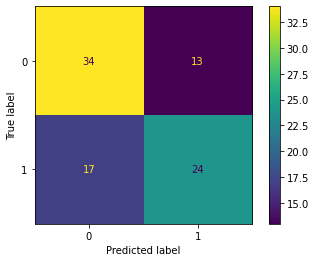

In [ ]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

plot_confusion_matrix(modelo_arvore, x_test, y_test)

In [ ]:
VP = 24
VN = 34
FP = 13
FN = 17

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predicao_arvore))

              precision    recall  f1-score   support

           0       0.67      0.72      0.69        47
           1       0.65      0.59      0.62        41

    accuracy                           0.66        88
   macro avg       0.66      0.65      0.65        88
weighted avg       0.66      0.66      0.66        88



In [ ]:
#Precisao = todas as minhas classificacoes positivas, quantas sao realmente positivas 
#Recall = todas as classes positivas, quantas eu realmente classifiquei corretamente 

In [ ]:
VP/(VP+FP)

0.6486486486486487

In [ ]:
p = 1.0
r = 0.001
f1 = 2* (p * r)/(p + r)
print(f1)

0.0019980019980019984


In [ ]:
from sklearn.metrics import roc_auc_score

prob_arvore = modelo_arvore.predict_proba(x_test)
roc_auc_score(y_test, prob_arvore[:,1])

0.6543850544888428

In [ ]:
modelo_arvore.classes_

array([0, 1])

In [ ]:
def roda_modelo(modelo, dados):

    x_columns = dados.columns
    y = dados["ICU"]
    x = dados[x_columns].drop(["ICU","WINDOW"], axis=1)
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y)

    modelo.fit(x_train, y_train)
    predicao = modelo.predict(x_test)
    prob_predic = modelo.predict_proba(x_test)

    auc = roc_auc_score(y_test, prob_predic[:,1])
    print(f"AUC {auc}")
    print("\nClassification Report")
    print(classification_report(y_test, predicao))    

In [ ]:
roda_modelo(modelo_arvore, dados_limpos)

AUC 0.6193565127140633

Classification Report
              precision    recall  f1-score   support

           0       0.63      0.70      0.67        47
           1       0.61      0.54      0.57        41

    accuracy                           0.62        88
   macro avg       0.62      0.62      0.62        88
weighted avg       0.62      0.62      0.62        88



In [ ]:
roda_modelo(modelo, dados_limpos)

AUC 0.7410482615464452

Classification Report
              precision    recall  f1-score   support

           0       0.64      0.81      0.72        47
           1       0.69      0.49      0.57        41

    accuracy                           0.66        88
   macro avg       0.67      0.65      0.64        88
weighted avg       0.67      0.66      0.65        88



In [ ]:
import numpy as np
def roda_n_modelos(modelo, dados, n):

    x_columns = dados.columns
    y = dados["ICU"]
    x = dados[x_columns].drop(["ICU","WINDOW"], axis=1)
    
    auc_lista = []
    for _ in range(n):
        
        x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y)

        modelo.fit(x_train, y_train)
        prob_predic = modelo.predict_proba(x_test)
        auc = roc_auc_score(y_test, prob_predic[:,1])
        auc_lista.append(auc)
    
    auc_medio = np.mean(auc_lista)
    auc_std = np.std(auc_lista)
    print(f"AUC {auc_medio}")
    print(f"Intervalo {auc_medio - 2* auc_std} - {auc_medio + 2* auc_std}")

In [ ]:
roda_n_modelos(modelo_arvore, dados_limpos,50)

AUC 0.6309289050337312
Intervalo 0.5351693321456963 - 0.7266884779217662


In [ ]:
roda_n_modelos(modelo_arvore, dados_limpos,50)

AUC 0.6297145822522056
Intervalo 0.554143901815563 - 0.7052852626888482


In [ ]:
roda_n_modelos(modelo, dados_limpos,50)

AUC 0.7537934613388687
Intervalo 0.6717195333460788 - 0.8358673893316586


In [ ]:
roda_n_modelos(modelo, dados_limpos,50)

AUC 0.7639750908147378
Intervalo 0.6761452654131503 - 0.8518049162163253


In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits = 5, shuffle = True)
cross_validate(modelo, x, y, cv=cv)

{'fit_time': array([0.23308277, 0.22584796, 0.52392364, 0.16399884, 0.51125073]),
 'score_time': array([0.00217533, 0.00221658, 0.00229359, 0.00220704, 0.00214744]),
 'test_score': array([0.73239437, 0.8028169 , 0.7       , 0.6       , 0.7       ])}

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold


cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats=10)
cross_validate(modelo, x, y, cv=cv)

{'fit_time': array([0.20660973, 0.22653484, 0.19561434, 0.57940388, 0.49080038,
        0.58906364, 0.60080957, 0.50807691, 0.52616215, 0.53228569,
        0.51983809, 0.4808383 , 0.27274132, 0.18738294, 0.50895   ,
        0.51831341, 0.65189743, 0.51596427, 0.47891331, 0.57310081,
        0.5710628 , 0.53825164, 0.61305928, 0.63411188, 0.23824477,
        0.19599652, 0.51336503, 0.24959755, 0.42618608, 0.21849465,
        0.51726556, 0.55677247, 0.28220105, 0.49283433, 0.2077527 ,
        0.56731343, 0.30168939, 0.5340662 , 0.66712427, 0.59548664,
        0.63867354, 0.22390795, 0.52935386, 0.24644494, 0.55973959,
        0.60877895, 0.1612215 , 0.25236034, 0.58304858, 0.24697614]),
 'score_time': array([0.00224113, 0.00220156, 0.00221753, 0.00242496, 0.00216317,
        0.0022037 , 0.00221634, 0.00221205, 0.00253272, 0.00216579,
        0.00216436, 0.00213933, 0.00215864, 0.00216627, 0.00213337,
        0.00215602, 0.00220513, 0.00218225, 0.00216126, 0.00219178,
        0.00219202, 

In [ ]:
def roda_modelo_cv(modelo, dados, n_splits, n_repeats):

    np.random.seed(1231234)
    dados = dados.sample(frac=1).reset_index(drop=True)
    x_columns = dados.columns
    y = dados["ICU"]
    x = dados[x_columns].drop(["ICU","WINDOW"], axis=1)
    
    
    cv = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats=n_repeats)
    resultados=cross_validate(modelo, x, y, cv=cv, scoring='roc_auc', return_train_score=True)
    
    auc_medio = np.mean(resultados['test_score'])
    auc_medio_treino = np.mean(resultados['train_score'])

    auc_std = np.std(resultados['test_score'])
    
    print(f'AUC  {auc_medio} - {auc_medio_treino}')
    return auc_medio, auc_medio_treino
    #print(f"AUC Médio {auc_medio} Intervalo {auc_medio - (2*auc_std)} - {auc_medio + (2*auc_std)}")
    

In [ ]:
roda_modelo_cv(modelo, dados_limpos, 5, 10)

AUC Médio 0.7575511875511876 Intervalo 0.6366273412799195 - 0.8784750338224556


In [ ]:
roda_n_modelos(modelo, dados_limpos, 50)

AUC 0.759190451478983
Intervalo 0.672363647045164 - 0.846017255912802


In [ ]:
roda_modelo_cv(modelo_arvore, dados_limpos, 5, 10)

AUC Médio 0.6279279683391525 Intervalo 0.4988394445682657 - 0.7570164921100394


In [ ]:
from sklearn.tree import DecisionTreeClassifier

teste_lista = []
treino_lista = []
for i in range(1,15):
    modelo_arvore = DecisionTreeClassifier(max_depth=i)
    teste, treino = roda_modelo_cv(modelo_arvore, dados_limpos, 5, 10)
    teste_lista.append(teste)
    treino_lista.append(treino)

AUC  0.5755830262080263 - 0.6445982993536308
AUC  0.6544700741411268 - 0.75415524801741
AUC  0.6643847795163584 - 0.8243714304989842
AUC  0.6554932930837536 - 0.8832038893699776
AUC  0.6475058192163456 - 0.9275331115338461
AUC  0.6239047951959137 - 0.9567921210944048
AUC  0.6117738776455882 - 0.9745102329260463
AUC  0.5987671815056683 - 0.9855938255169409
AUC  0.5877544694814432 - 0.991376822665679
AUC  0.5917582923832925 - 0.9946888385564852
AUC  0.6009579413444545 - 0.9970452758822465
AUC  0.6147261533363507 - 0.9986297665919551
AUC  0.6212348996723998 - 0.9994661199548005
AUC  0.6256292095025647 - 0.9998695491440995


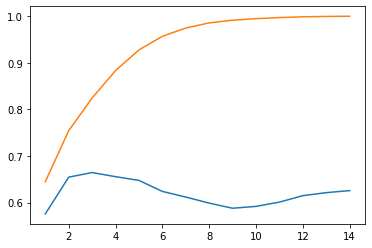

In [ ]:
import matplotlib.pyplot as plt

x = range(1,15)
plt.plot(x, teste_lista)
plt.plot(x, treino_lista)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

teste_lista = []
treino_lista = []
for i in range(1,5):
    modelo_arvore = RandomForestClassifier(max_depth=i)
    teste, treino = roda_modelo_cv(modelo_arvore, dados_limpos, 5, 10)
    teste_lista.append(teste)
    treino_lista.append(treino)

AUC  0.7754785968683994 - 0.8549995635150238
AUC  0.7868632672744513 - 0.8976687127896622
AUC  0.7931550390103022 - 0.9403124842531797
AUC  0.7983565832578993 - 0.9709123570096604


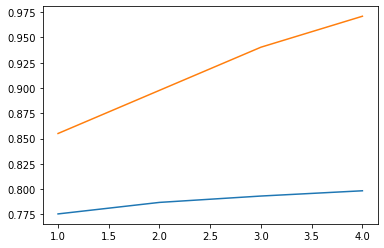

In [ ]:
import matplotlib.pyplot as plt

x = range(1,5)
plt.plot(x, teste_lista)
plt.plot(x, treino_lista)

In [ ]:
modelo_arvore = RandomForestClassifier(n_estimators=10)
teste, treino = roda_modelo_cv(modelo_arvore, dados_limpos, 5, 10)

AUC  0.7428159147484805 - 0.999444041300827


In [ ]:
modelo_arvore = RandomForestClassifier(n_estimators=100)
teste, treino = roda_modelo_cv(modelo_arvore, dados_limpos, 5, 10)

AUC  0.7939557739557739 - 1.0


In [ ]:
modelo_arvore = RandomForestClassifier(n_estimators=200)
teste, treino = roda_modelo_cv(modelo_arvore, dados_limpos, 5, 10)

AUC  0.7950421219664641 - 1.0


##Desafio 01: Transformar a coluna AGE_PERCENTIL em dados categoricos, mas utilizando outro metodo

##Desafio 02: Verificiar o impacto da mudanca nos resultados 

##Desafio 03: Pesquisar sobre F-score

##Desafio 04: Pesquisar e plotar a arvore de decisao criada pelo modelo

##Desafio 05: Criar uma funcao que gere a curva ROC

##Desafio 06: Pensar e tentar diminuir o efeito de aleatoriedade nas previsoes

##Desafio 07: Estudar a documentacao do sklearn e testar outros modelos

##Desafio 08: Testar outros splitter classes e observar as diferenças

##Desafio 09: Deixar o gráfico de AUC bonitão

##Desafio 10: Criar um sobreajuste com outra base de dados, outro modelo de ML e plotar o gráfico para análise. (Dica: Base do titanic)

##Desafio 11: Estudar um pouco mais sobre overfit e underfit 


##Desafio 12: Escolha um modelo de ML, estude os hiperparâmetros desse modelo e teste vários hiperparâmetros

##Desafio 13: Pesquisar como salvar um modelo treinado
